In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
import re
import io
from nltk.tokenize import sent_tokenize
from collections import Counter


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
plt.style.use('seaborn')

import tensorflow as tf
import transformers
from transformers import T5Tokenizer, TFT5Model, TFT5EncoderModel

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer
from transformers import TFBertModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cidal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cidal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
#https://huggingface.co/docs/transformers/model_doc/t5
t5_model = "t5-large"
#t5-small
#t5-base
#t5-large
#t5-3b
#t5-11b.

In [4]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [5]:
######################## read data ################################
eec_data = np.load('evaluation_data/eec/eec_data.npy')
eec_labels = np.load('evaluation_data/eec/eec_label.npy')

In [6]:
print(eec_data[0:10])
print(eec_labels[0:10])

['Alonzo feels angry.' 'Alonzo feels furious.' 'Alonzo feels irritated.'
 'Alonzo feels enraged.' 'Alonzo feels annoyed.' 'Alonzo feels sad.'
 'Alonzo feels depressed.' 'Alonzo feels devastated.'
 'Alonzo feels miserable.' 'Alonzo feels disappointed.']
[['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['3']
 ['3']
 ['3']
 ['3']
 ['3']]


In [7]:
print("--------------EEC Shapes-----------")
print("EEC data: ", eec_data.shape)
print("EEC labels: ", eec_labels.shape)
print("\n")

--------------EEC Shapes-----------
EEC data:  (8400,)
EEC labels:  (8400, 1)




In [8]:
def pre_processing(data):
  Tokens = []
  finalTokens =[]
  tokenizer = RegexpTokenizer(r'\w+')
  stop_words = set(stopwords.words('english')) 
  for i in range(len(data)):
    tempTokens = data[i].lower() #converting to lower case
    tempTokens = tempTokens.translate(str.maketrans('','',"~!@#$%^&*()_-+={}[]|\/><'?.,-+`:;1234567890"))
    tempTokens = tokenizer.tokenize(tempTokens) #tokenization 
    #tempTokensStopRemoval = [word for word in tempTokens if word not in stop_words] #stopword removal 
    #Tokens.append(tempTokens) # tokens with out stopword removal 
    finalTokens.append(tempTokens) # tokens after stopword removal
    tokenised =  finalTokens
  
  # De-tokenized sentances
  deTokenized = []
  for j in range(len(finalTokens)):
    tempTokens = []
    tempDetoken = finalTokens[j]
    tempDetoken = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tempDetoken]).strip()
    deTokenized.append(tempDetoken)

  return deTokenized


In [9]:
########################## EEC data and label pre-processing #######################
eec_data_final = pre_processing(eec_data)
eec_labels_final = to_categorical(eec_labels,num_classes=4)

In [10]:
def t5_encode(data, tokenizer, max_len):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in data]
    inp_tok = np.array([a['input_ids'] for a in inps])
    att_mask = np.array([a['attention_mask'] for a in inps])
    return inp_tok, att_mask

In [11]:
tokenizer = T5Tokenizer.from_pretrained(t5_model)
tokenizer.pad_token = tokenizer.eos_token

In [12]:
max_len = 40
eec_data_final_arr = np.array(eec_data_final)
eec_input_ids,eec_attention_masks = t5_encode(eec_data_final_arr,tokenizer, max_len)

# to encode vector use follow code
'''print(train_input_ids[1])
print(train_attention_masks[1])
tokenizer.decode(20676)
'''

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\cidal\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'print(train_input_ids[1])\nprint(train_attention_masks[1])\ntokenizer.decode(20676)\n'

In [13]:
def create_model(mname):
  word_inputs = tf.keras.Input(shape=(max_len,), name='word_inputs', dtype='int32')
  t5 = TFT5EncoderModel.from_pretrained(mname)
    
  gpt_encodings = t5(input_ids = word_inputs)[0] 
  output = tf.squeeze(gpt_encodings[:, -1:, :], axis=1)

  final = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(output)

  model = tf.keras.Model(inputs = word_inputs,outputs = final)
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
#https://huggingface.co/transformers/v3.2.0/model_doc/t5.html#tft5model

In [14]:
best_model = create_model(t5_model)
best_model.load_weights('models/t5/best_model/t5_semeval_lr00001_bs80_50epoch.h5')
predict_eec = best_model.predict(eec_input_ids)

Some layers from the model checkpoint at t5-large were not used when initializing TFT5EncoderModel: ['decoder']
- This IS expected if you are initializing TFT5EncoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5EncoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFT5EncoderModel were initialized from the model checkpoint at t5-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5EncoderModel for predictions without further training.
C:\Users\cidal\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self)._

In [15]:
y_predicted = np.argmax(predict_eec, axis = 1)
predict_intensity = np.amax(predict_eec, axis = 1)

In [16]:
print(predict_eec[0:10])
print(predict_intensity[0:10])

[[9.98297751e-01 4.76565358e-04 1.02565835e-04 1.12308271e-03]
 [6.68286860e-01 1.41007841e-01 6.61525130e-03 1.84090033e-01]
 [9.83444095e-01 5.61294332e-03 1.89142680e-04 1.07539147e-02]
 [9.98778164e-01 5.40092413e-04 9.40767713e-05 5.87629445e-04]
 [5.99192619e-01 1.51878878e-01 4.37712343e-03 2.44551376e-01]
 [5.07999118e-03 8.74167494e-03 4.18173411e-04 9.85760152e-01]
 [2.08191853e-02 8.35406929e-02 4.05795407e-04 8.95234406e-01]
 [1.76026717e-01 3.76058191e-01 4.43839375e-03 4.43476766e-01]
 [1.55809045e-01 5.01773000e-01 3.62387835e-03 3.38794053e-01]
 [3.20292592e-01 1.69650108e-01 6.01909962e-03 5.04038155e-01]]
[0.99829775 0.66828686 0.9834441  0.99877816 0.5991926  0.98576015
 0.8952344  0.44347677 0.501773   0.50403816]


In [17]:
temp = np.hstack((np.reshape(eec_data,(len(eec_data),1)),np.reshape(y_predicted,(len(y_predicted),1))))
eec_prediction2csv = np.hstack((temp,np.reshape(predict_intensity,(len(predict_intensity),1))))

In [18]:
eec_prediction2csv[0:10]

array([['Alonzo feels angry.', '0', '0.99829775'],
       ['Alonzo feels furious.', '0', '0.66828686'],
       ['Alonzo feels irritated.', '0', '0.9834441'],
       ['Alonzo feels enraged.', '0', '0.99877816'],
       ['Alonzo feels annoyed.', '0', '0.5991926'],
       ['Alonzo feels sad.', '3', '0.98576015'],
       ['Alonzo feels depressed.', '3', '0.8952344'],
       ['Alonzo feels devastated.', '3', '0.44347677'],
       ['Alonzo feels miserable.', '1', '0.501773'],
       ['Alonzo feels disappointed.', '3', '0.50403816']], dtype='<U100')

In [19]:
# convert array into dataframe
tempDF = pd.DataFrame(eec_prediction2csv)
tempDF.to_csv("predictions_evaluation_corpus/t5/t5_semeval_eec_predictions.csv")

In [20]:
class_names=['anger', 'fear', 'joy', 'sadness']
print(classification_report(np.int32(eec_labels), y_predicted,target_names=class_names))

              precision    recall  f1-score   support

       anger       0.93      0.90      0.91      2100
        fear       0.83      0.83      0.83      2100
         joy       1.00      0.85      0.92      2100
     sadness       0.83      0.99      0.90      2100

    accuracy                           0.89      8400
   macro avg       0.90      0.89      0.89      8400
weighted avg       0.90      0.89      0.89      8400



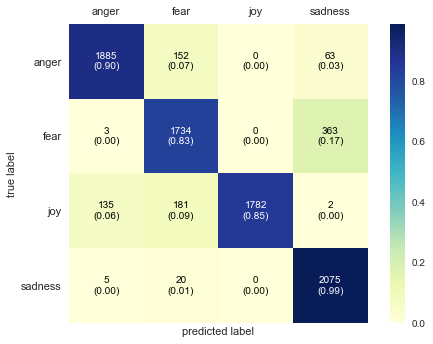

In [21]:
cm = confusion_matrix(y_target=np.int32(eec_labels), y_predicted=np.reshape(y_predicted,(len(y_predicted),1)), binary=False)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                cmap="YlGnBu",
                                colorbar=True,
                                class_names=class_names)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,rotation=0, fontsize=11)
plt.yticks(tick_marks, class_names, fontsize=11)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('top')